In [274]:
import numpy as np
import pandas as pd

from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import LCG

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

In [275]:
class Discrete2D:
    def __init__(self, n, m, theor=None):
        self.gen = BasicRand(LCG())
        self.n = n
        self.m = m
        self.total = n * m
        self.theor = self._create_theor(theor)
        self.x_prob_t, self.y_prob_t = self._build_components(self.theor)
    
    def _create_theor(self, theor):
        if theor: return np.array(theor)
        return np.array([[1 / self.total] * self.m] * self.n)
    
    def _build_components(self, Z):
        x_probs = [np.sum(Z[i, :]) for i in range(self.n)]
        y_probs = [np.sum(Z[:, i]) for i in range(self.m)]
        return x_probs, y_probs
        
    
    def get_emp(self, cnt):
        Z = np.zeros((self.n, self.m))
        
        for i in range(cnt):
            x, y = self.next_pos()
            Z[x][y] += 1

        return self._norm(Z)
    
    def next_pos(self):
        x = self._next_id(self.gen, self.x_prob_t)
        y = self._next_id(self.gen, self.theor[x, :], self.x_prob_t[x])
        return x, y
    
    @staticmethod
    def _norm(mat):
        return np.array(mat) / np.sum(mat)
    
    @staticmethod
    def _next_id(gen, probs, max_prob=1):
        cur_prob = 0
        gen_prob = gen.next() * max_prob
        for i in range(len(probs)):
            cur_prob += probs[i]
            if cur_prob >= gen_prob:
                return i

In [276]:
n = 10
m = 10
dis = Discrete2D(n, m)

emp = dis.get_emp(1000)

In [277]:
xvals = np.arange(n)
yvals = np.arange(m)

x_t = dis.x_prob_t
y_t = dis.y_prob_t

x_emp = [np.sum(emp[i, :]) for i in range(n)]
y_emp = [np.sum(emp[:, i]) for i in range(m)]

In [278]:
def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        plt.annotate('{0:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords='offset points',  # in both directions
                    ha=ha[xpos], 
                    va='bottom',
                    rotation=90)

def plot_distr(n, emp, theor, title):
    xrange = np.arange(n)

    width = 0.425

    fig, ax = plt.subplots()

    rects_pract = ax.bar(xrange - width / 2, emp, width, label='Practical')
    rects_theor = ax.bar(xrange + width / 2, theor, width, label='Theor')

    autolabel(rects_pract)
    autolabel(rects_theor)

    ax.set_ylim((0, ax.get_ylim()[1] * 1.25))
    fig.tight_layout()

    ax.set_title(title)
    ax.set_xticks(xrange)
    ax.legend()
    plt.show()

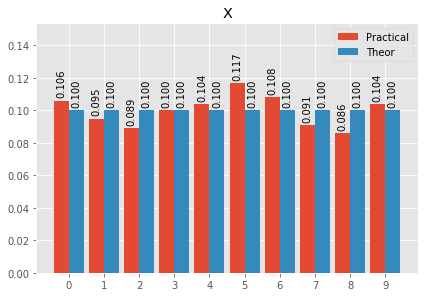

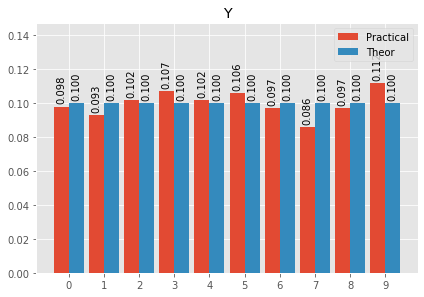

In [279]:
plot_distr(n, x_emp, x_t, 'X')
plot_distr(m, y_emp, y_t, 'Y')

### Точечные оценки компонент

#### Матожидание

In [280]:
def expectation_table(mat, vals, axis=0):
    n, m = mat.shape
    
    res = 0
    for i in range(n):
        for j in range(m):
            val_id = j if axis else i
            res += mat[i, j] * vals[val_id]
    
    return res

In [281]:
m_x = expectation_table(emp, xvals)
m_y = expectation_table(emp, yvals, 1)

In [282]:
print('E[X]:', m_x)
print('E[Y]:', m_y)

E[X]: 4.4830000000000005
E[Y]: 4.524


#### Дисперсия

In [283]:
def dispersion_table(mat, vals, e_x, axis=0):
    n, m = mat.shape
    
    res = 0
    for i in range(n):
        for j in range(m):
            val_id = j if axis else i
            res += mat[i, j] * (vals[val_id] - e_x)**2
    
    return res

In [284]:
d_x = dispersion_table(emp, xvals, m_x)
d_y = dispersion_table(emp, yvals, m_y, 1)

In [285]:
print('D[X]:', d_x)
print('D[Y]:', d_y)

D[X]: 8.117710999999998
D[Y]: 8.265424000000001


#### Корелляция

In [286]:
def expectation_xy_table(mat, xvals, yvals):
    n, m = mat.shape

    res = 0
    for i in range(n):
        for j in range(m):
            res += mat[i, j] * xvals[i] * yvals[j]
    
    return res

In [287]:
m_xy = expectation_xy_table(emp, xvals, yvals)

covariance = m_xy - m_x * m_y
r = covariance / (np.sqrt(d_x) * np.sqrt(d_y)) 

In [288]:
r

0.05980881117238483

In [292]:
from statlib.metrics import get_exp_interval

alpha_e = 0.05
laplace_e = (1 - alpha_e)

interval_len_x = get_exp_interval(d_x, laplace_e, n * m)
interval_len_y = get_exp_interval(d_y, laplace_e, n * m)

In [294]:
print('Interval for E(X) with alpha = {} is ({}, {})'.format(alpha_e, m_x - interval_len_x, m_x + interval_len_x))
print('Interval for E(Y) with alpha = {} is ({}, {})'.format(alpha_e, m_y - interval_len_y, m_y + interval_len_y))

Interval for E(X) with alpha = 0.05 is (3.1477553619106144, 5.818244638089387)
Interval for E(Y) with alpha = 0.05 is (3.1644587355308254, 5.883541264469175)


### Критерий хи-квадрат

In [297]:
def calc_chi(theor, emp):
    n, m = emp.shape
    
    chi_val = 0
    for i in range(n):
        for j in range(m):
            chi_val += (theor[i, j] - emp[i, j])**2 / theor[i, j]
    
    return chi_val

In [298]:
calc_chi(dis.theor, emp)

0.09560000000000002